In [1]:
#pip install keras_tuner

In [2]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch

In [3]:
df= pd.read_csv("../src/Real_Combine.csv")
df.head()

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4,219.720833
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1,182.187500
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1,154.037500
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6,223.208333
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2,200.645833


In [4]:
df.isnull().sum() 

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    1
dtype: int64

In [5]:
df= df.dropna()
df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    0
dtype: int64

In [6]:
x= df.iloc[:, :-1]
y= df.iloc[:, -1]

In [7]:
def hyper_tune(param):
    model= keras.Sequential()
    for i in range(param.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units= param.Int('units_'+ str(i),
                                               min_value= 32,
                                               max_value= 512,
                                               step= 32),
                              activation= 'tanh'))
        model.add(layers.Dense(1, activation= 'linear'))
        model.compile(optimizer= keras.optimizers.Adam(
        param.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                     loss= 'mean_absolute_error',
                     metrics= ['mean_absolute_error'])
    return model

In [8]:
tuner= RandomSearch(
    hyper_tune,
    objective= 'val_mean_absolute_error',
    max_trials= 5,
    executions_per_trial= 3,
    directory= 'project',
    overwrite= True,
    project_name= 'Air Quality Index')

In [9]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


# Model Fitting

In [10]:
from sklearn.model_selection import train_test_split as tts

x_train, x_test, y_train, y_test= tts(x, y, test_size= 0.3, random_state= 2)
tuner.search(x_train, y_train, epochs= 5, validation_data= (x_test, y_test))

Trial 5 Complete [00h 00m 08s]
val_mean_absolute_error: 64.09166463216145

Best val_mean_absolute_error So Far: 64.09166463216145
Total elapsed time: 00h 00m 27s
INFO:tensorflow:Oracle triggered exit


# Plotting

Epoch 1/5
24/24 [==============================] - 2s 9ms/step - loss: 84.2309 - mean_absolute_error: 84.2309 - val_loss: 64.7541 - val_mean_absolute_error: 64.7541
Epoch 2/5
24/24 [==============================] - 0s 3ms/step - loss: 66.8725 - mean_absolute_error: 66.8725 - val_loss: 64.5683 - val_mean_absolute_error: 64.5683
Epoch 3/5
24/24 [==============================] - 0s 3ms/step - loss: 66.8959 - mean_absolute_error: 66.8959 - val_loss: 64.4600 - val_mean_absolute_error: 64.4600
Epoch 4/5
24/24 [==============================] - 0s 3ms/step - loss: 66.7867 - mean_absolute_error: 66.7867 - val_loss: 64.1821 - val_mean_absolute_error: 64.1821
Epoch 5/5
24/24 [==============================] - 0s 3ms/step - loss: 66.8530 - mean_absolute_error: 66.8530 - val_loss: 64.0209 - val_mean_absolute_error: 64.0209


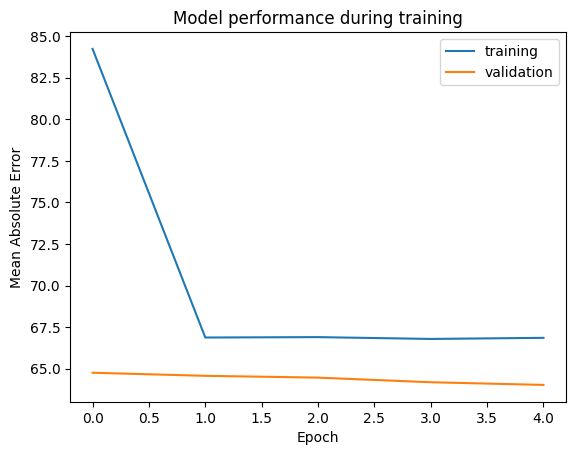

In [11]:
import matplotlib.pyplot as plt

best_hps= tuner.get_best_hyperparameters(1)[0] #Get the best hyperparameters found during the search
model= hyper_tune(best_hps) #Build the model with the best parameters 
history= model.fit(x_train, y_train, epochs= 5, validation_data= (x_test, y_test)) #Training the model with the best parameters

#Plot the training and validation metrics for each epoch
plt.plot(history.history['mean_absolute_error'], label= 'training')
plt.plot(history.history['val_mean_absolute_error'], label= 'validation')
plt.title('Model performance during training')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()